In [1]:
from IPython.display import Image

### MySQL 
 
 #### mysql 접속 ( worker-02 )

  - sudo mysql -u root
  - mysql.txt 참고 

$ show tables;

$ show databases;

$ use mysql

$ show tables;

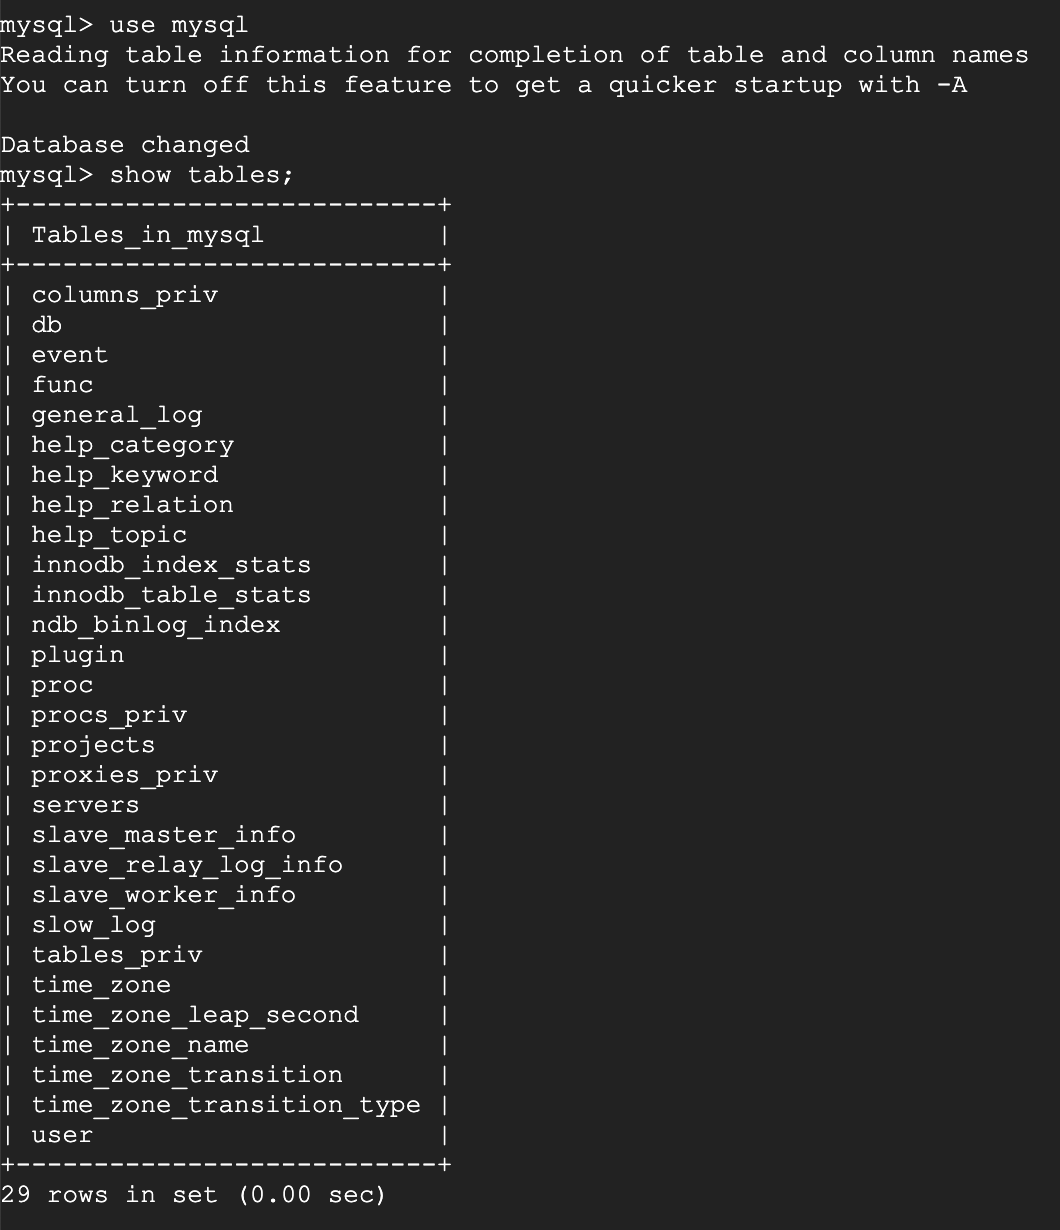

In [4]:
Image('./capture/show_tables.png')

$ describe projects;

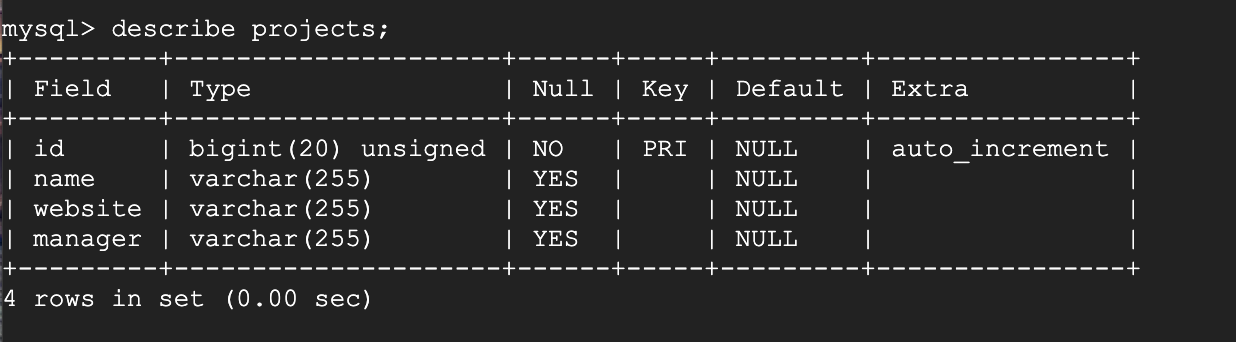

In [5]:
Image('./capture/describe projects.png')

$ select * from projects;

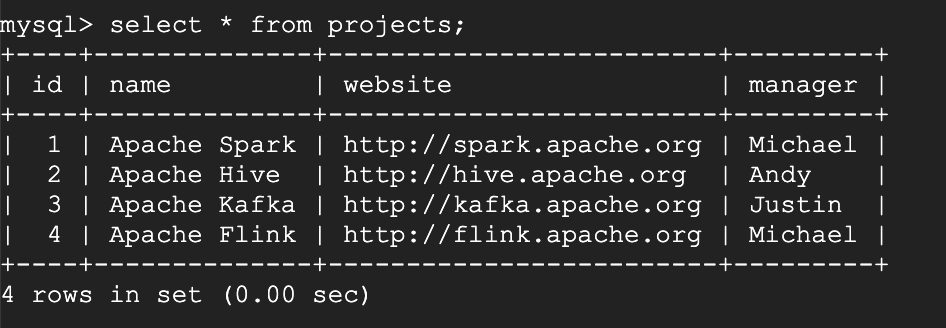

In [6]:
Image('./capture/select * from projects.png')

-----
### MySQL JDBC Driver download
  - https://dev.mysql.com/downloads/connector/j/
  
--------  
  - Platform Independent --> zip file download --> unzip
                              (mysql-connector-java-8.0.19)
--------
  - worker-02에서 하면 구글 계정으로 올라감.
  - zeppelin으로 올려야하기 때문에 worker-03 옵션에서 파일 업로드
          (mysql-connector-java-8.9.19.jar)
 

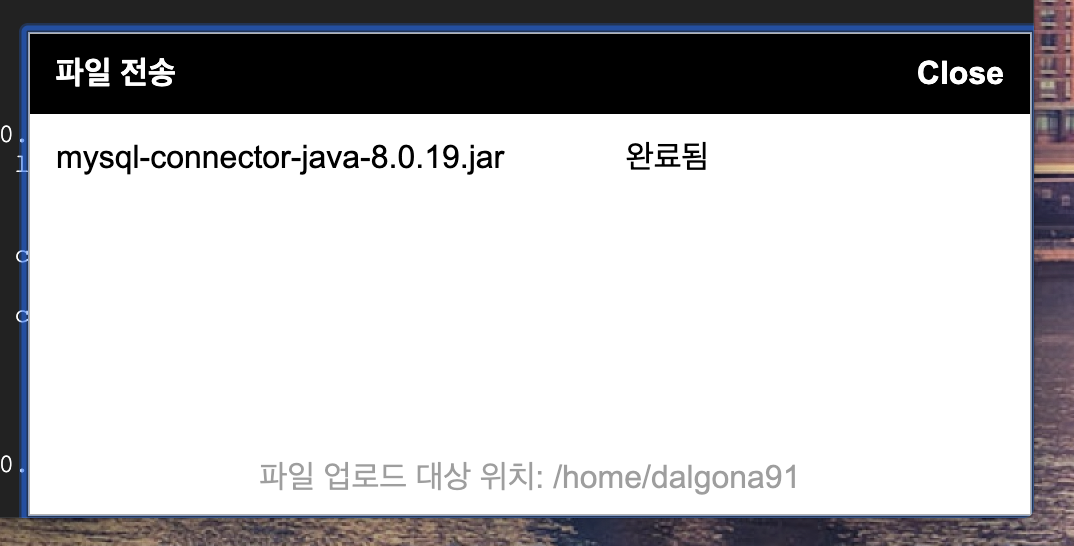

In [7]:
Image('./capture/worker3_file_upload.png')

--> 업로드 후 파일 업로드 대상 위치로 이동

$ sudo ls -al /home/@본인구글계정

$ sudo cp /home/@본인구글계정/mysql-connector-java-8.0.19.jar /kikang/spark2/

$ sudo chown hadoop:hadoop ./mysql-connector-java-8.0.19.jar 

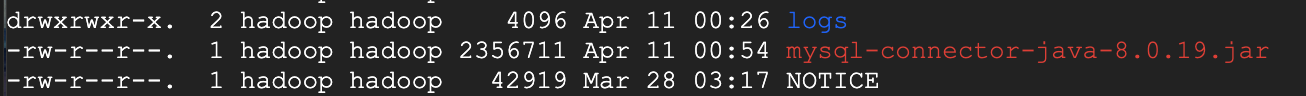

In [9]:
Image('./capture/chown change.png')

----
### zeppelin에서 connect

 - zeppelin에서 아래 코드 실행

val df = spark.\
   read.\
   format("jdbc").\
   option("url", "jdbc:mysql://hadoop-worker-02:3306/mysql").\
   option("driver", "com.mysql.jdbc.Driver").\
   option("dbtable", "projects").\
   option("user", "root").\
   option("password", "").\
   load() 

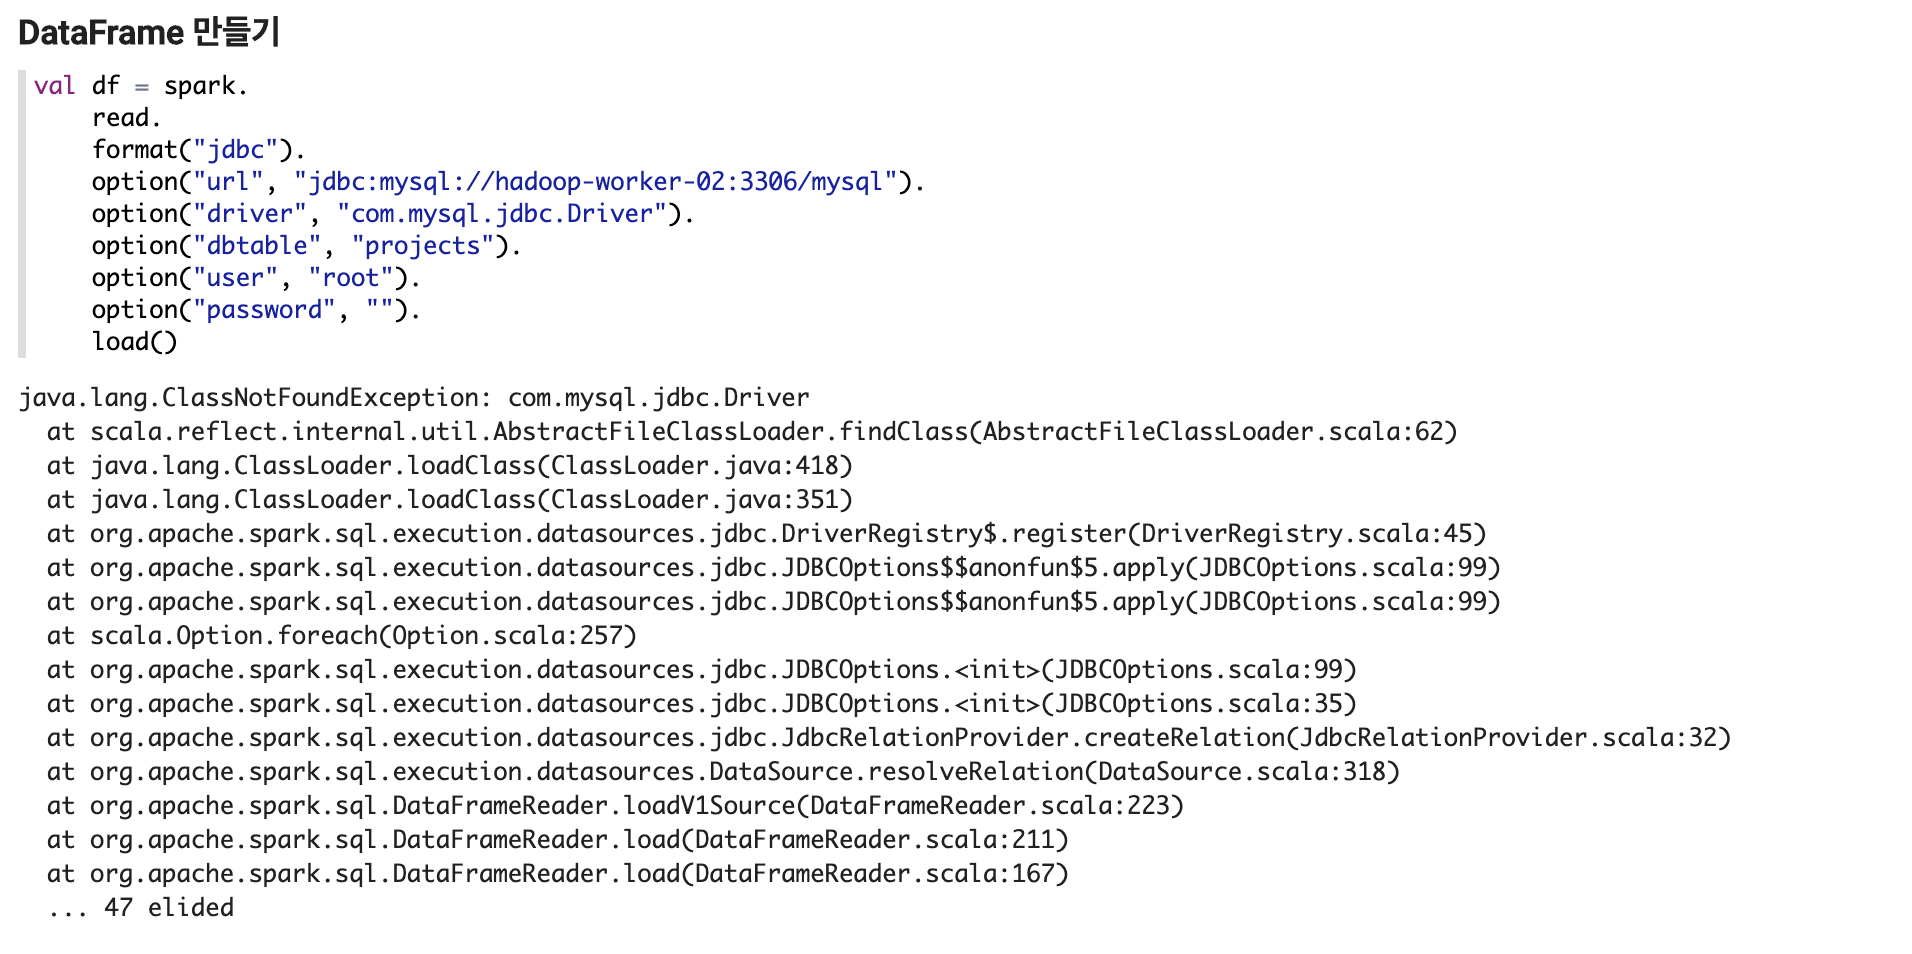

In [10]:
Image('./capture/zeppelin_sql.png')

--> 오류.

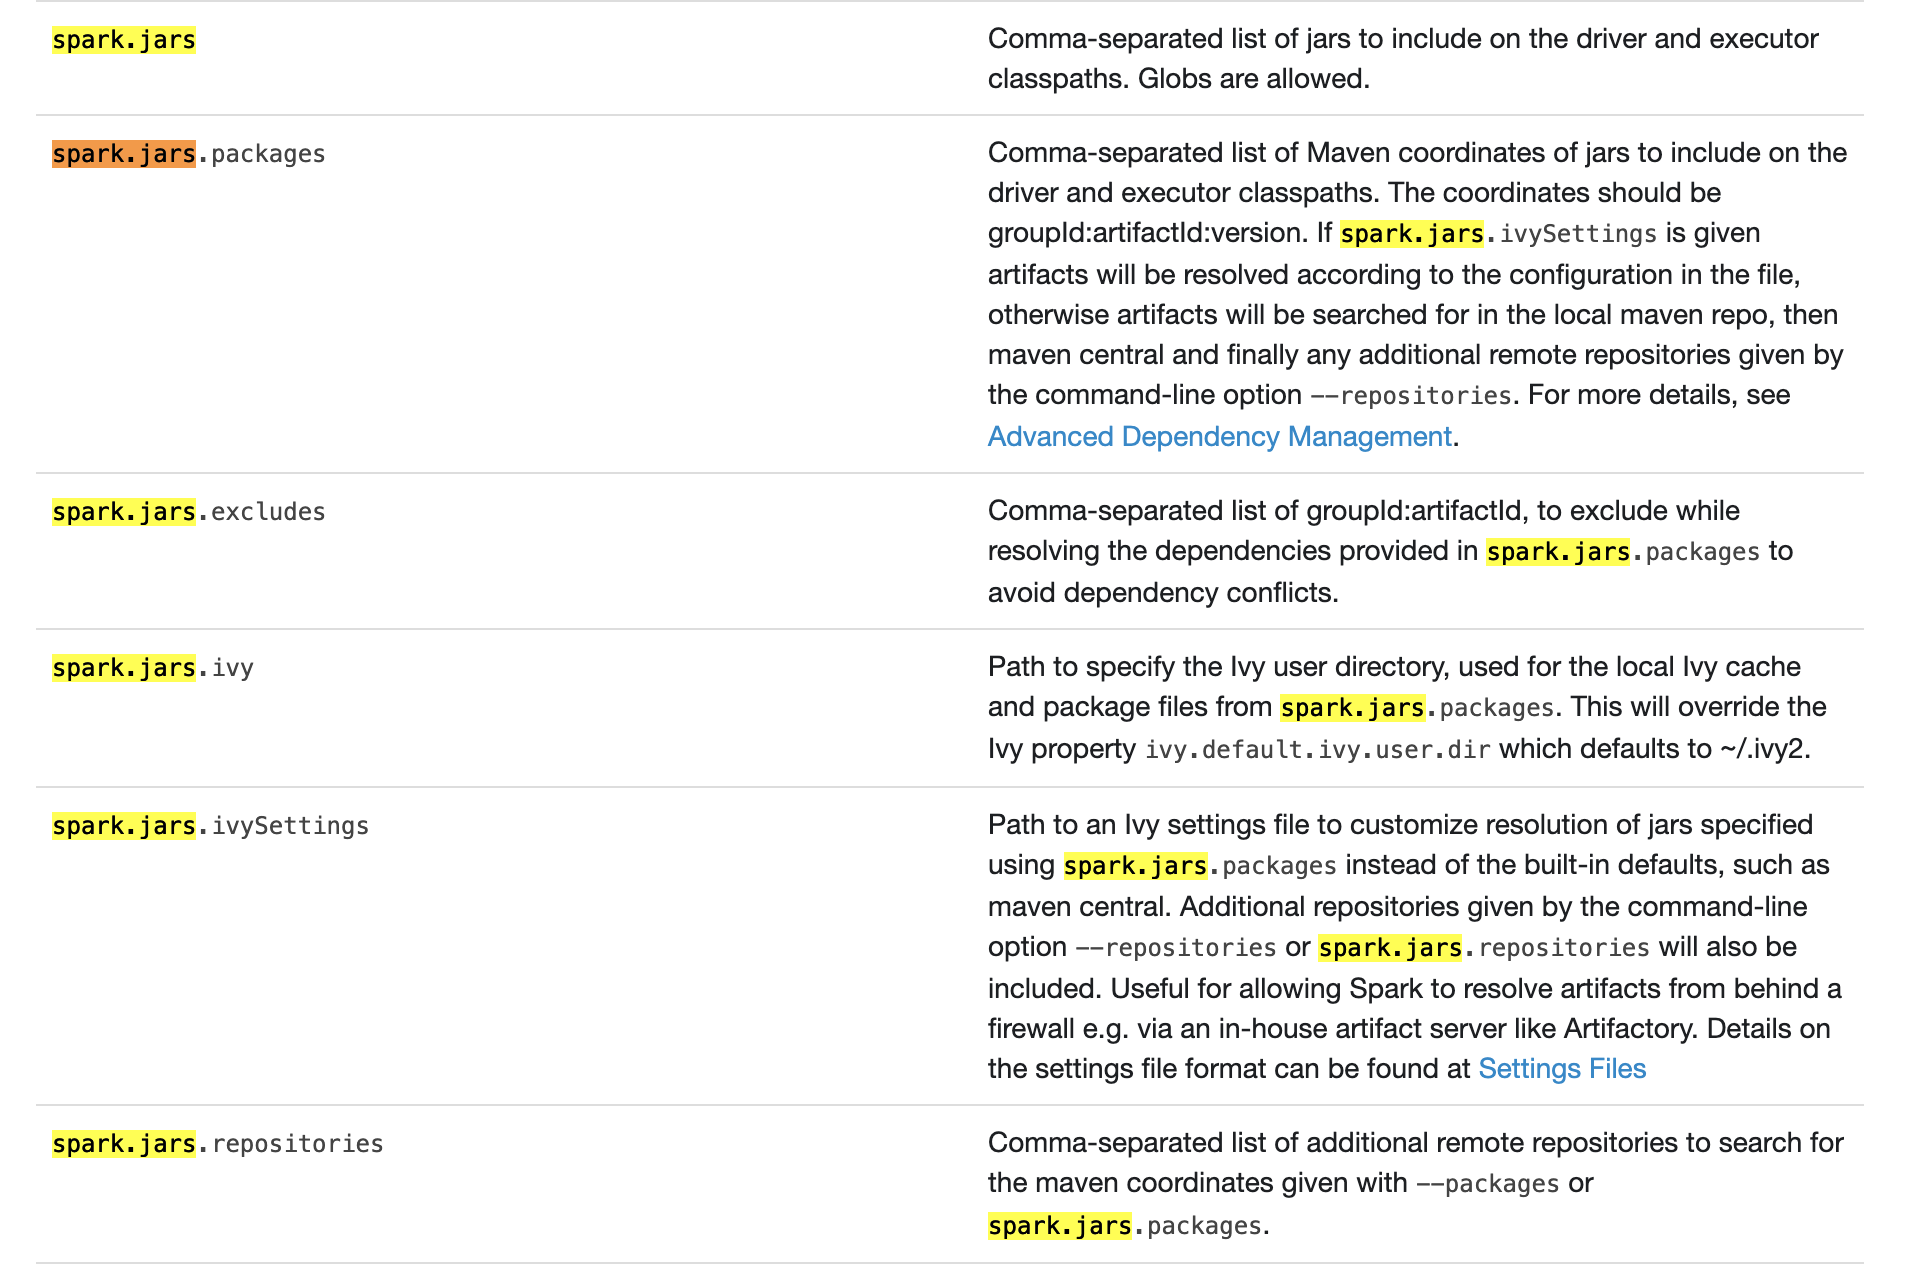

In [11]:
Image('./capture/spark.jars.configuration.png')

- zeppelin과 관련된 설정은 모두 interpreter

#### spark2 interpreter 에 추가
 - spark.jars // /kikang/spark2/mysql-connector-java-8.0.19.jar

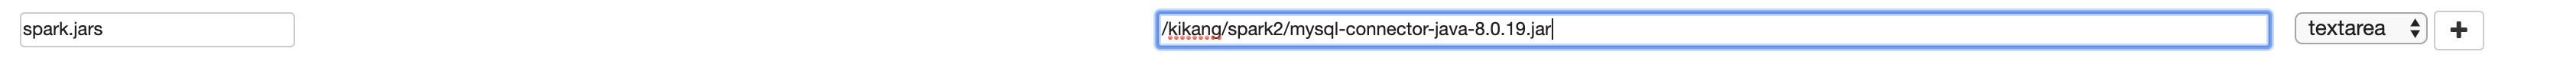

In [12]:
Image('./capture/spark.jars.png')

#### 다시 실행 

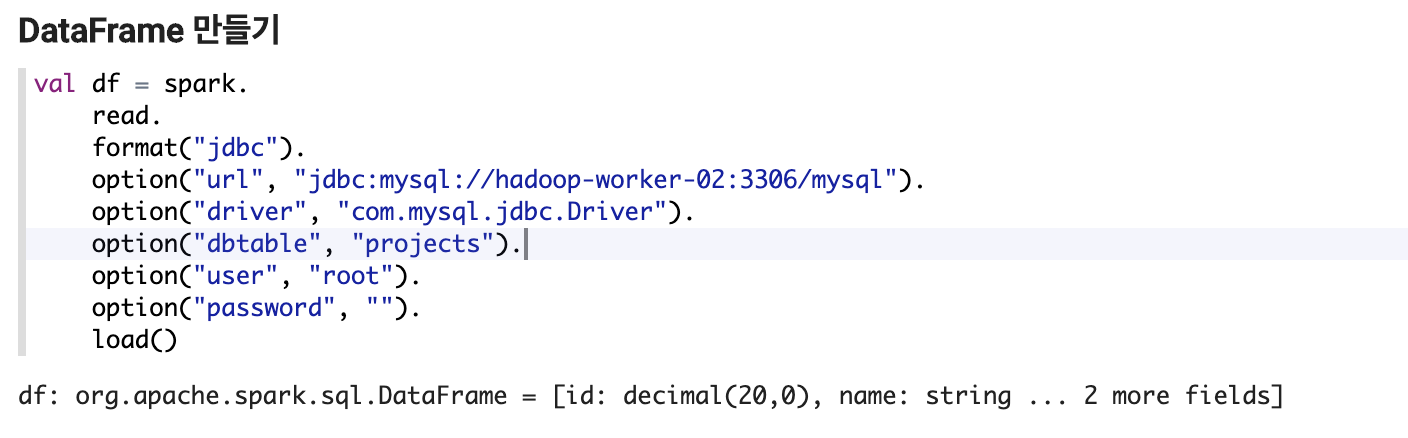

In [13]:
Image('./capture/schema info.png')

- executor의 실행 파일들은 /kikang/spark2/work에 저장됨 

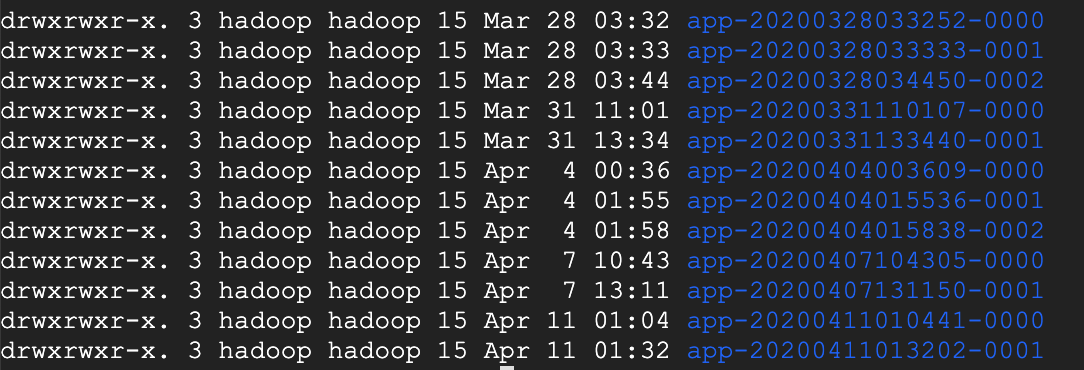

In [14]:
Image('./capture/worker-01_work.png')

#### 스키마 정보 
 - df.printSchema

#### DataFrame 을 가져올 수 있음 
 - df.show(false)

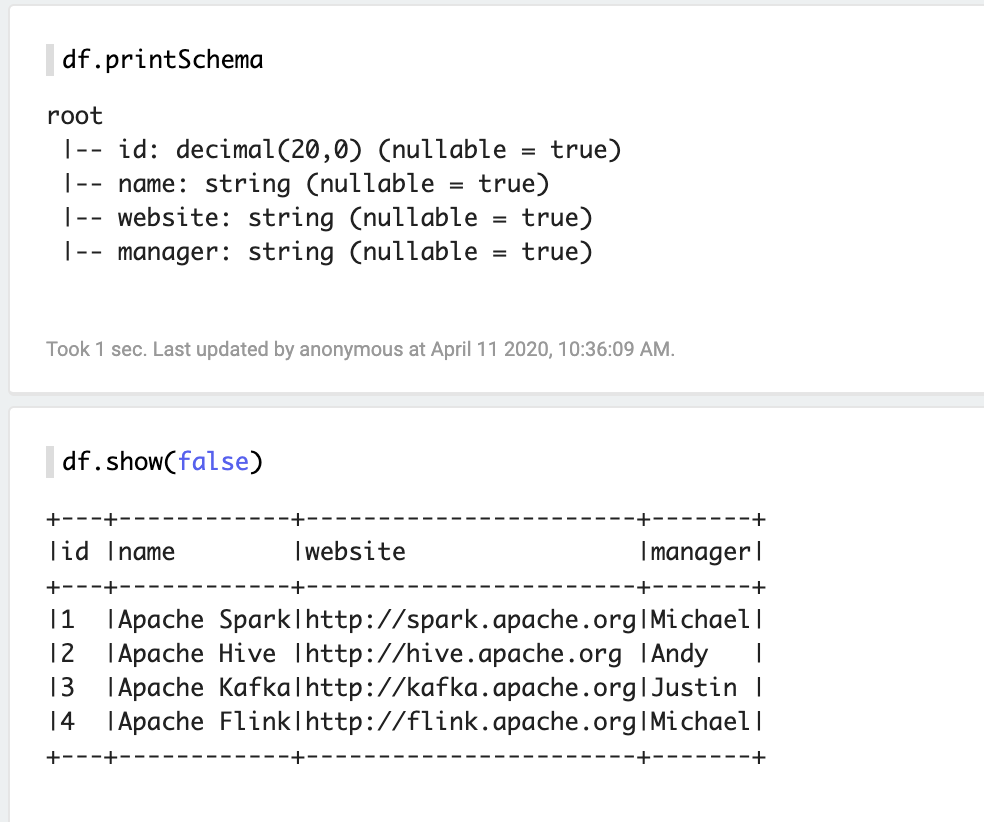

In [15]:
Image('./capture/schema_database_show.png')

------
#### work-01/kikang/spark2/work/app-20200411013202-0001

drwxrwxr-x. 2 hadoop hadoop 34 Apr 11 01:32 0 
    < 마지막에 써있는 번호 0 == 해당 executor ID >
----------
#### work-02/kikang/spark2/work/app-20200411013202-0001

drwxrwxr-x. 2 hadoop hadoop 34 Apr 11 01:32 1

-----
- cache 확인
    - df.persist
    - df.show(false)

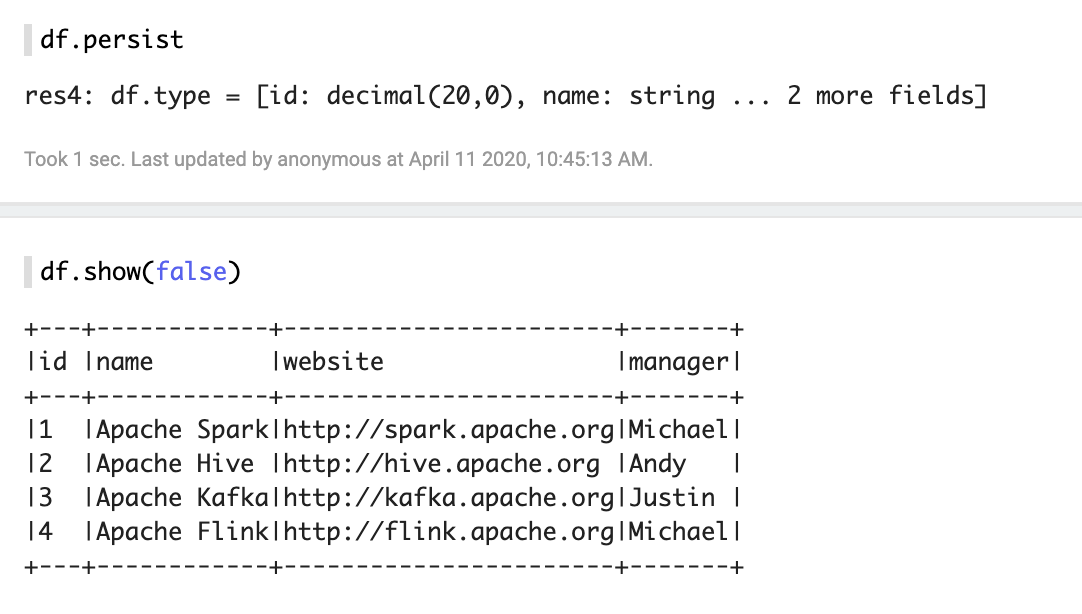

In [18]:
Image('./capture/cache.png')

#### cache 해제 
    - df.unpersist
    - df.show(false)
    
----
#### Teamview 생성
 - df.createOrReplaceTempView("df")
 - spark.sql("select * from df").show(false)
 
----
#### Table 확인

%sql\
SELECT * FROM df
 
 ---

%sql\
select df2.name\
from \
(select * from df where id >= 3) as df2

----
#### DataFrame 만들기 - from MySQL w/ SubQuery

    val subdf = spark.
        read.
        format("jdbc").
        option("url", "jdbc:mysql://hadoop-worker-02:3306/mysql").
        option("driver", "com.mysql.jdbc.Driver").
        option("dbtable", "(SELECT * FROM projects WHERE id > 3) as subprojects").
        option("user", "root").
        option("password", "").
        load()


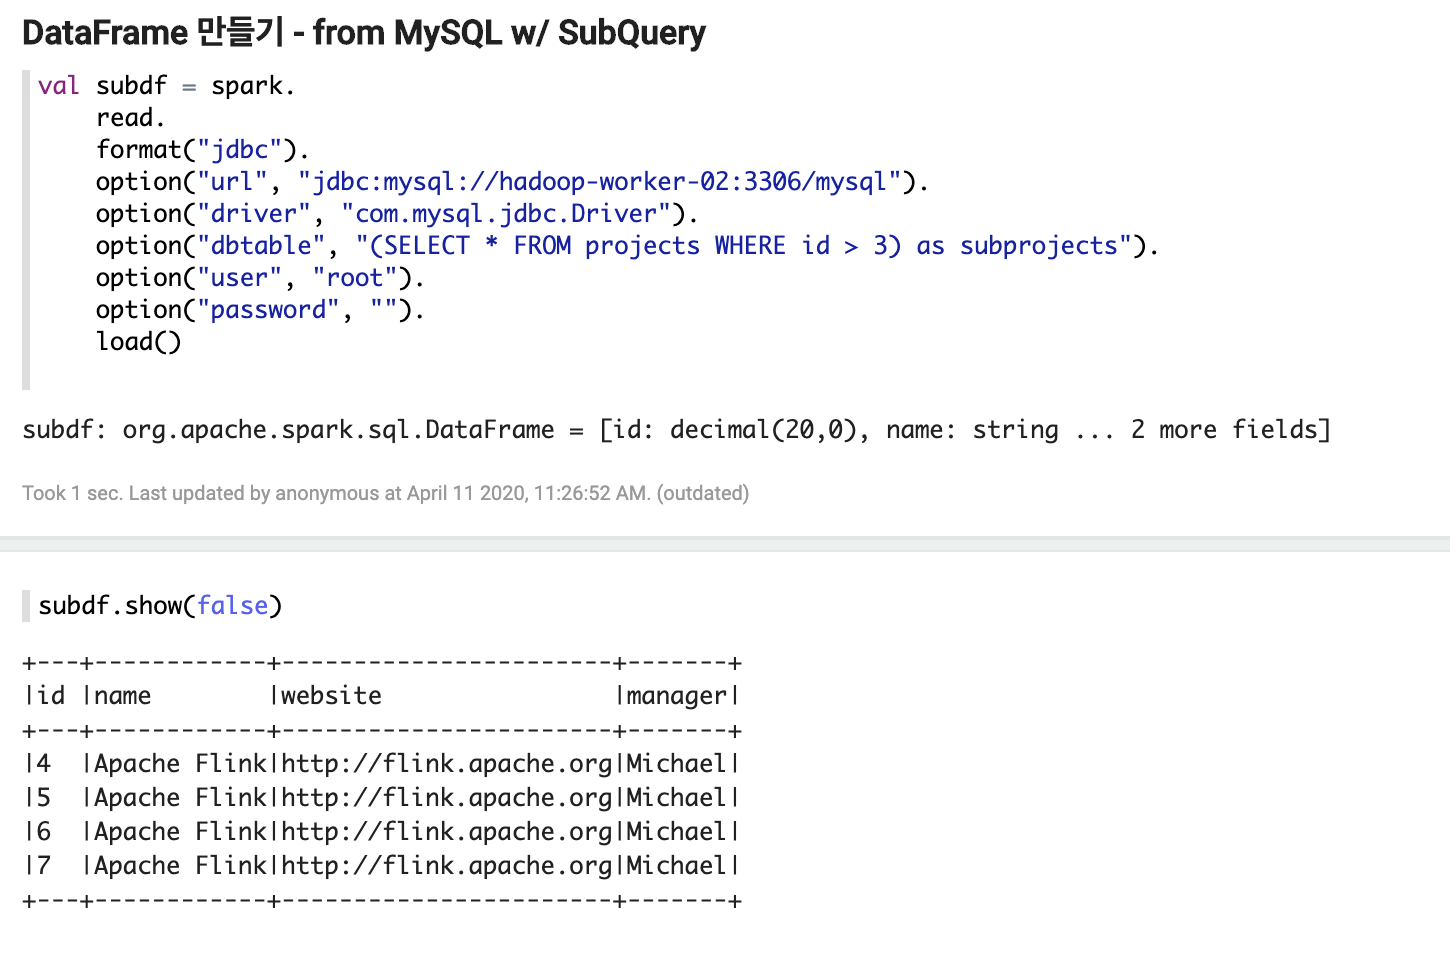

In [19]:
Image('./capture/subQuery.png')

----

#### 저장 
- subdf.write.format("parquet").save("hdfs://hadoop-master-01:9090/kikang/data/mysql/subdf")

 == subdf.write.mode("append").parquet("hdfs://hadoop-master-01:9090/kikang/data/mysql/subdf")
 - append하면 계속 파일 추가
 
 == subdf.write.mode("overwirte").parquet("hdfs://hadoop-master-01:9090/kikang/data/mysql/subdf")
 - 덮어씀

#### prop 만들고 저장


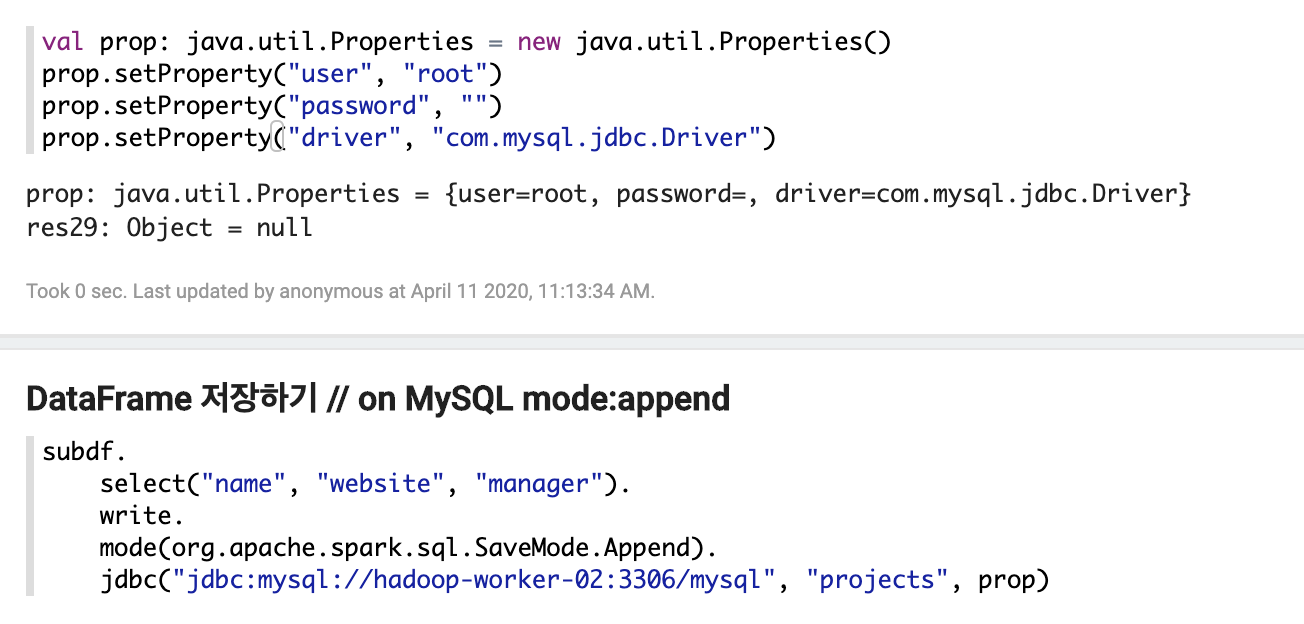

In [17]:
Image('./capture/make_prop_save.png')

#### mode:Overwrite

    subdf.
        select("name", "website", "manager").
        write.
        mode(org.apache.spark.sql.SaveMode.Overwrite).
        jdbc("jdbc:mysql://hadoop-worker-02:3306/mysql", "projects_new", prop) 

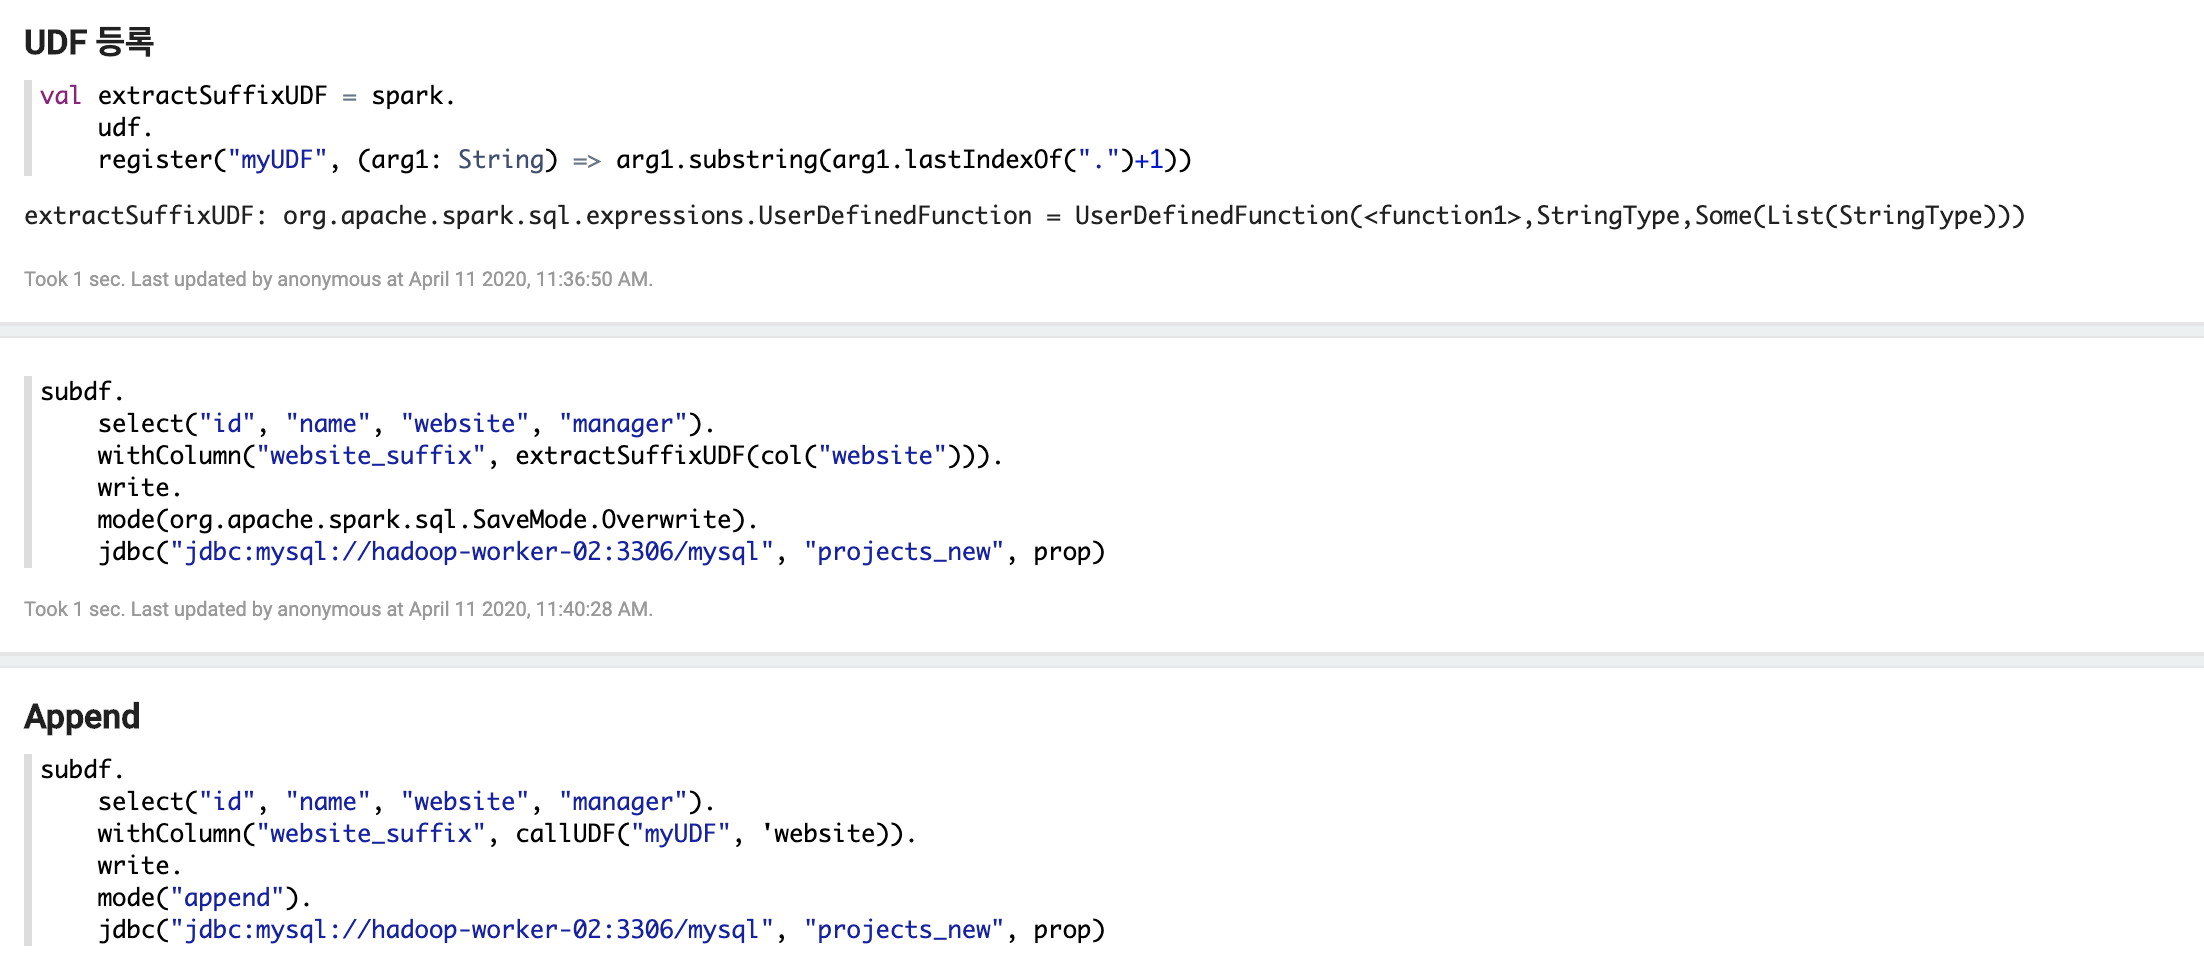

In [23]:
Image('./capture/UDF.png')

### UDF 등록 

    val extractSuffixUDF = spark.
        udf.
        register("myUDF", (arg1: String) => arg1.substring(arg1.lastIndexOf(".")+1))
        
 -----       
        
    subdf.
        select("id", "name", "website", "manager").
        withColumn("website_suffix", extractSuffixUDF(col("website"))).
        write.
        mode(org.apache.spark.sql.SaveMode.Overwrite).
        jdbc("jdbc:mysql://hadoop-worker-02:3306/mysql", "projects_new", prop) 
        
        
 #### save : append
 
    subdf.
        select("id", "name", "website", "manager").
        withColumn("website_suffix", callUDF("myUDF", 'website)).
        write.
        mode("append").
        jdbc("jdbc:mysql://hadoop-worker-02:3306/mysql", "projects_new", prop) 

#### Database / Table확인

    spark.sql("show databases").show()
    spark.sql("show tables").show()

----
#### projects table이 없을경우

    df.createOrReplaceTempView("projects")
    
----
#### 다시 table 확인

    spark.sql("show tables").show()

---------------

#### Overwrite

    spark.
        sql("""
            SELECT id, name, website, manager, myUDF(website) as website_suffix_by_sql 
            FROM projects
        """).
        write.
        mode(org.apache.spark.sql.SaveMode.Overwrite).
        jdbc("jdbc:mysql://hadoop-worker-02:3306/mysql", "projects_new", prop) 
        
        
------

#### SaveAsTable == warehouse에 저장 // 영구저장

    spark.
        sql("""
            SELECT id, name, website, manager, myUDF(website) as website_suffix_by_sql 
            FROM projects
        """).
        write.
        mode(org.apache.spark.sql.SaveMode.Overwrite).saveAsTable("projects_new")

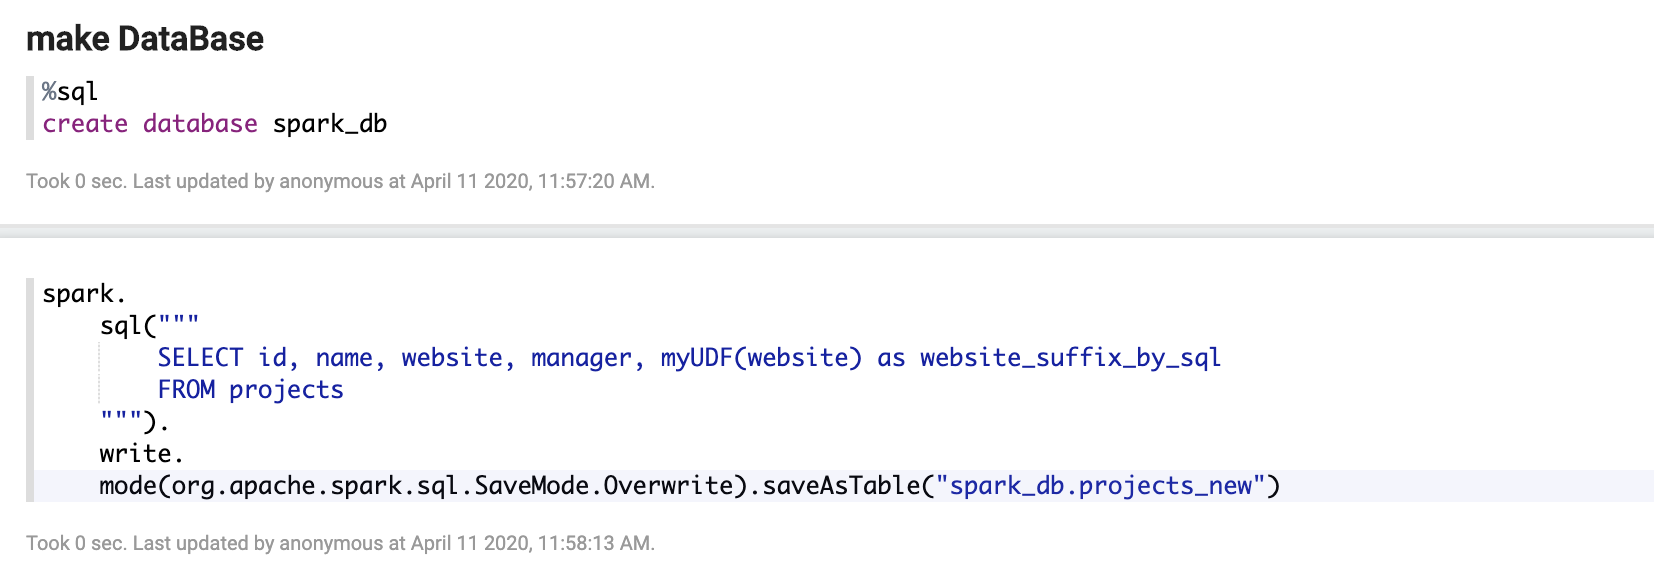

In [24]:
Image('./capture/make_Database_Save.png')

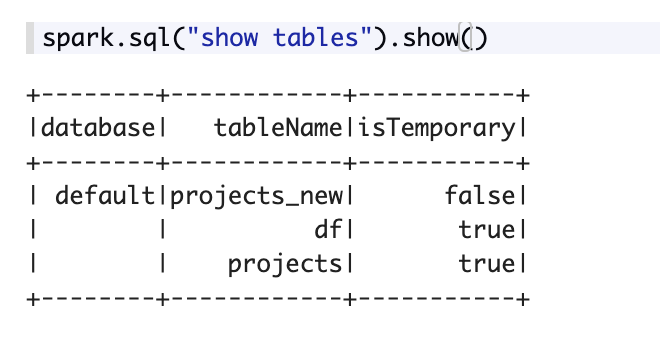

In [27]:
# projects_new는 sql을 껐다 켜도 그대로 유지

Image('./capture/saveastable.png')

#### Table 확인

    %sql
    select * from spark_db.projects_new
  
------
  
    %sql
    use spark_db

    %sql
    select * from projects_new


----
#### 현재 DB확인

 - spark.catalog.currentDatabase


---- 
#### hadoop-master-01

 $ cd /kikang/spark2/example/src/main/resources
 
----
#### hdfs 로 파일 업로드

 $ /kikang/hadoop3/bin/hdfs dfs -put ./resources /kikang/data

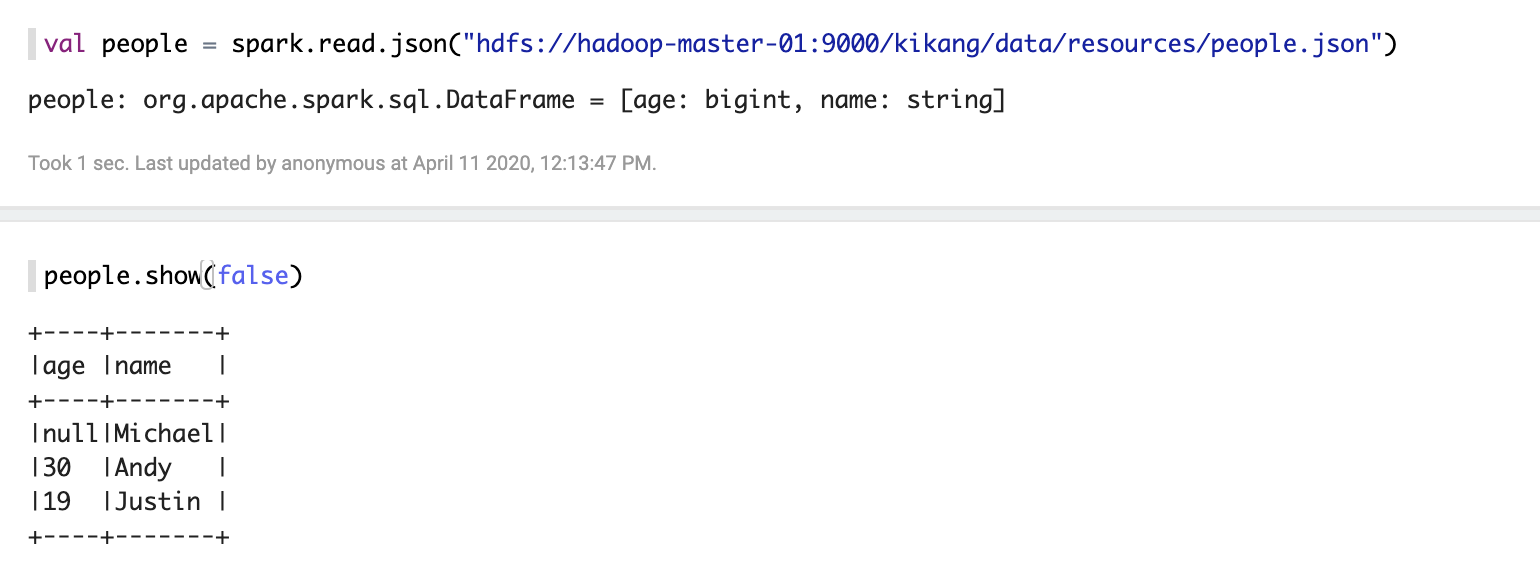

In [21]:
Image('./capture/people.png')

val people = spark.read.json("hdfs://hadoop-master-01:9000/kikang/data/resources/people.json")

-----

people.show(false)

-----

df.show(false)

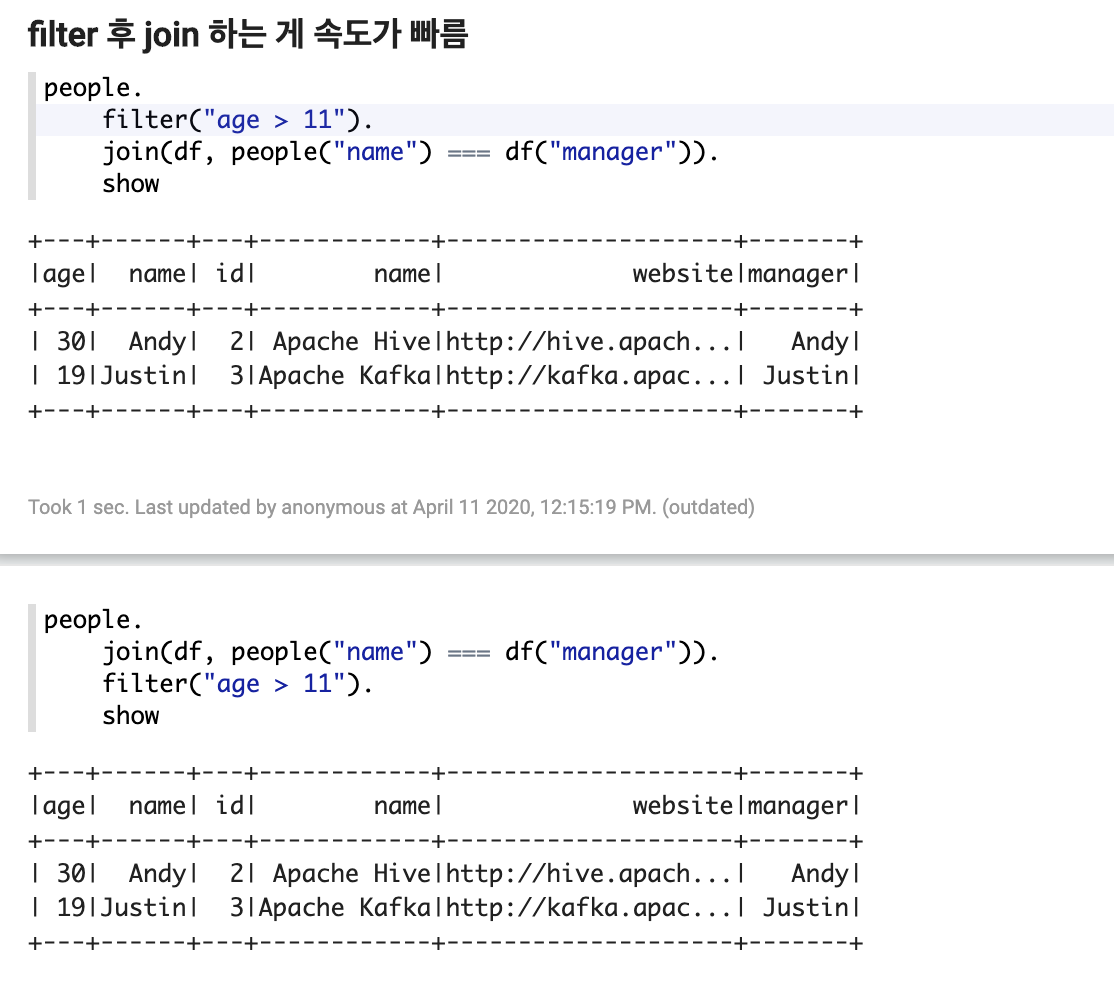

In [22]:
Image('./capture/sql_filter_join.png')

    people.
        filter("age > 11").
        join(df, people("name") === df("manager")).
        show
    
---- 

    people.
        join(df, people("name") === df("manager")).
        filter("age > 11").
        show

 - sql 에서 알아서 순서를 지정해서 실행 
----- 


    people.
        filter("age > 11").
        join(df, people("name") === df("manager")).
        groupBy(df("website")).
        agg(avg(people("age")), max(df("id"))).
        show


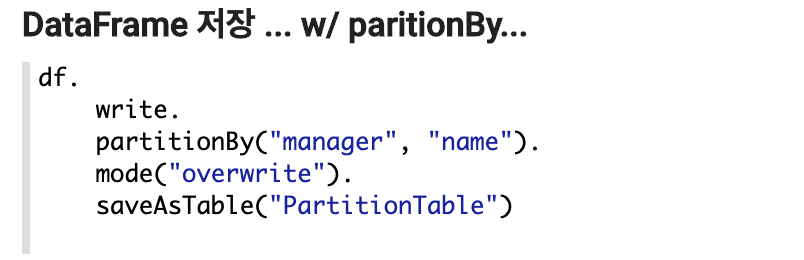

In [25]:
Image('./capture/partitionBy.png')

df.show(false)

----
    val tdf = spark.read.parquet("hdfs://hadoop-master-01:9000/spark-warehouse2/spark_db.db/partitiontable/manager=Andy/name=Apache Hive/*.parquet")

tdf.show(false)

    val tdf2 = spark.read.parquet("hdfs://hadoop-master-01:9000/spark-warehouse2/spark_db.db/partitiontable")

tdf2.show(false)


    val tdf3 = spark
        .read
        .parquet("hdfs://hadoop-master-01:9000/spark-warehouse2/spark_db.db/partitiontable")
        .filter('manager==="Andy")
        .filter('name==="Apache Hive")

tdf3.show(false)

-----

###  partition 으로 불러왔을 때 속도가 더 빠를까? 
----

#### DataFrame 저장 wo /PartitionBy(nonpartition으로 저장)

    df.
        write.
        mode("overwrite").
        saveAsTable("nonPartitionTable")

----

    val tdf4 = spark
        .read
        .parquet("hdfs://hadoop-master-01:9000/spark-warehouse2/spark_db.db/nonpartitiontable")
        .filter('manager==="Andy")
        .filter('name==="Apache Hive")
        
----

tdf4.show(false)

---- 
### spark에서 table은 RDB

-----
#### warehouse에 있는 table 확인

    spark
        .read
        .table("partitiontable")
        .filter('manager==="Andy")
        .filter('name==="Apache Hive")
        .show(false)

http://hadoop-worker-03:4040/SQL/ 에서 실행된 결과 확인 

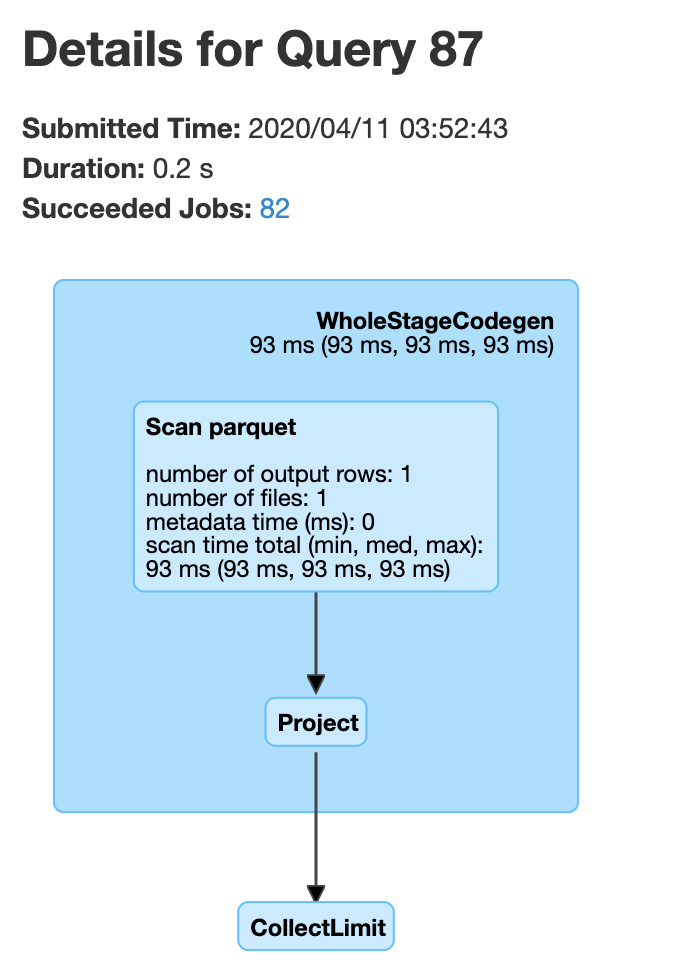

In [29]:
Image('./capture/4040.png')

- spark sql 엔진이 알아서 걸러서 처리 